In [4]:
#!pip install pycaret

## Import Libraries

In [21]:
import pandas as pd
from pycaret.classification import *

## Import Data

In [22]:
train = pd.read_csv("training.csv")
test = pd.read_csv("test.csv")

In [23]:
train.head()

,RefId,IsBadBuy,PurchDate,Auction,VehYear,VehicleAge,Make,Model,Trim,SubModel,...,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,PRIMEUNIT,AUCGUART,BYRNO,VNZIP1,VNST,VehBCost,IsOnlineSale,WarrantyCost
0,1,0,12/7/2009,ADESA,2006,3,MAZDA,MAZDA3,i,4D SEDAN I,...,11597.0,12409.0,NaN,NaN,21973,33619,FL,7100.0,0,1113
1,2,0,12/7/2009,ADESA,2004,5,DODGE,1500 RAM PICKUP 2WD,ST,QUAD CAB 4.7L SLT,...,11374.0,12791.0,NaN,NaN,19638,33619,FL,7600.0,0,1053
2,3,0,12/7/2009,ADESA,2005,4,DODGE,STRATUS V6,SXT,4D SEDAN SXT FFV,...,7146.0,8702.0,NaN,NaN,19638,33619,FL,4900.0,0,1389
3,4,0,12/7/2009,ADESA,2004,5,DODGE,NEON,SXT,4D SEDAN,...,4375.0,5518.0,NaN,NaN,19638,33619,FL,4100.0,0,630
4,5,0,12/7/2009,ADESA,2005,4,FORD,FOCUS,ZX3,2D COUPE ZX3,...,6739.0,7911.0,NaN,NaN,19638,33619,FL,4000.0,0,1020


In [24]:
train['train_or_test']='train'
test['train_or_test']='test'
df=pd.concat([train,test])

## Feat Engineering

In [25]:
df['mean_MMRAcquisitionAuctionAveragePrice_Make']=df.groupby(['Make'])['MMRAcquisitionAuctionAveragePrice'].transform('mean')
df['mean_MMRAcquisitionAuctionAveragePrice_Model']=df.groupby(['Model'])['MMRAcquisitionAuctionAveragePrice'].transform('mean')
df['mean_MMRAcquisitionAuctionAveragePrice_Trim']=df.groupby(['Trim'])['MMRAcquisitionAuctionAveragePrice'].transform('mean')
df['mean_MMRAcquisitionAuctionAveragePrice_SubModel']=df.groupby(['SubModel'])['MMRAcquisitionAuctionAveragePrice'].transform('mean')
df['mean_MMRAcquisitionAuctionAveragePrice_Color']=df.groupby(['Color'])['MMRAcquisitionAuctionAveragePrice'].transform('mean')
df['mean_MMRAcquisitionAuctionAveragePrice_Transmission']=df.groupby(['Transmission'])['MMRAcquisitionAuctionAveragePrice'].transform('mean')

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 121690 entries, 0 to 48706
Data columns (total 41 columns):
 #   Column                                               Non-Null Count   Dtype  
---  ------                                               --------------   -----  
 0   RefId                                                121690 non-null  int64  
 1   IsBadBuy                                             72983 non-null   float64
 2   PurchDate                                            121690 non-null  object 
 3   Auction                                              121690 non-null  object 
 4   VehYear                                              121690 non-null  int64  
 5   VehicleAge                                           121690 non-null  int64  
 6   Make                                                 121690 non-null  object 
 7   Model                                                121690 non-null  object 
 8   Trim                                                 11

In [31]:
train=df.loc[df.train_or_test.isin(['train'])]
train.IsBadBuy = train.IsBadBuy.astype(int)
test=df.loc[df.train_or_test.isin(['test'])]

In [32]:
train.IsBadBuy.value_counts()

0    64007
1     8976
Name: IsBadBuy, dtype: int64

## Setup PyCaret with Target Variable

In [33]:
exp_clf = setup(train, target = 'IsBadBuy')

Setup Succesfully Completed!


,Description,Value
0,session_id,8661
1,Target Type,Binary
2,Label Encoded,None
3,Original Data,"(72983, 41)"
4,Missing Values,True
5,Numeric Features,20
6,Categorical Features,19
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [10]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,Extreme Gradient Boosting,0.9004,0.7609,0.2297,0.8541,0.3614,0.3264,0.4112,11.6315
1,CatBoost Classifier,0.8995,0.7619,0.2366,0.8172,0.3660,0.3291,0.4054,15.7022
2,Light Gradient Boosting Machine,0.8994,0.7526,0.2409,0.8063,0.3705,0.3328,0.4060,1.4544
3,Gradient Boosting Classifier,0.8992,0.7553,0.2334,0.8154,0.3625,0.3256,0.4023,38.1254
4,Extra Trees Classifier,0.8974,0.7335,0.2393,0.7679,0.3641,0.3247,0.3914,5.2762
5,Ada Boost Classifier,0.8934,0.7452,0.2239,0.7129,0.3404,0.2993,0.3598,18.3566
6,Random Forest Classifier,0.8923,0.6951,0.1889,0.7517,0.3008,0.2644,0.3406,0.5674
7,Ridge Classifier,0.8919,0.0000,0.2594,0.6523,0.3705,0.3233,0.3651,1.8079
8,Linear Discriminant Analysis,0.8818,0.7187,0.2960,0.5353,0.3809,0.3216,0.3390,11.6942
9,Logistic Regression,0.8770,0.6317,0.0000,0.0000,0.0000,0.0000,0.0000,3.0134


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=4383,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=0)

In [34]:
xgb = create_model('xgboost', fold=5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9027,0.7752,0.2520,0.8533,0.3891,0.3528,0.4317
1,0.9016,0.7527,0.2396,0.8576,0.3746,0.3391,0.4219
2,0.9013,0.7724,0.2423,0.8431,0.3764,0.3401,0.4197
3,0.9020,0.7542,0.2538,0.8343,0.3892,0.3520,0.4270
4,0.8995,0.7590,0.2255,0.8416,0.3556,0.3203,0.4039
Mean,0.9014,0.7627,0.2426,0.8460,0.3770,0.3409,0.4208
SD,0.0011,0.0093,0.0102,0.0084,0.0123,0.0118,0.0094


In [35]:
tuned_xgb = tune_model(xgb)

IntProgress(value=0, description='Processing: ', max=16)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,19:21:01
Status,. . . . . . . . . . . . . . . . . .,Searching Hyperparameters
ETC,. . . . . . . . . . . . . . . . . .,Calculating ETC


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC


MemoryError: Unable to allocate 264. MiB for an array with shape (2260, 15326) and data type float64

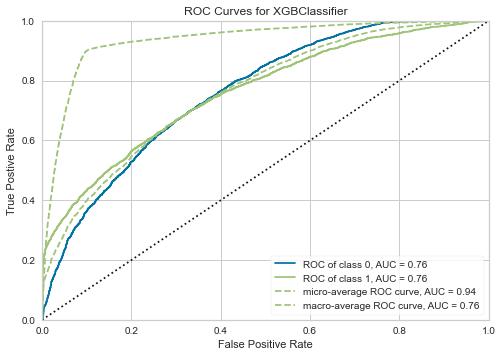

In [21]:
# AUC plot
plot_model(xgb, plot = 'auc')

In [ ]:
# confusion_matrix
plot_model(xgb, plot = 'confusion_matrix')

In [22]:
optimize_threshold(xgb, true_negative = 10, false_negative = -100)

Optimized Probability Threshold: 0.09 | Optimized Cost Function: 38810


In [23]:
test_pred = predict_model(xgb, data = test, probability_threshold = 0.09)

In [24]:
test_pred['IsBadBuy'] = test_pred['Score'].apply(lambda x: 1 if x > 0.09 else 0)

In [25]:
test_pred[['RefId','IsBadBuy']].to_csv('PyCaret_xgb_Output_Optimized.csv', index = False)

In [26]:
save_model(xgb, 'xgb_Basic_Opti', verbose=True)

Transformation Pipeline and Model Succesfully Saved
